In [561]:
import json
import requests
from sklearn.decomposition import PCA
from pandas.io.json import json_normalize
from datapackage import Package

In [231]:
import numpy as np
import matplotlib.pyplot as plt


In [47]:
import os
import time
import numpy as np
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import string
import random
from IPython.core.display import display, HTML
import datetime

display(HTML("<style>.container { width:100% !important; }</style>"))

# (2020-05-05)

# An Exploratory Analysis of FDA Adverse Events Data

## Logistics

###### Prompt:

The U.S. Food and Drug Administration (FDA) regulates over-the-counter and prescription drugs in the United States, including biological therapeutics and generic drugs. This work covers more than just medicines. For example, fluoride toothpaste, antiperspirants, dandruff shampoos and sunscreens are all considered drugs. 
 
An adverse event is submitted to the FDA to report any undesirable experience associated with the use of a medical product in a patient. For drugs, this includes serious drug side effects, product use errors, product quality problems, and therapeutic failures for prescription or over-the-counter medicines and medicines administered to hospital patients or at outpatient infusion centers. 
 
The FDA's database of adverse event reports is made available through a web API at https://open.fda.gov/apis/try-the-api/ Each report contains general information about the report, patient information, a list of the drugs that the patient is taking, and a list of the patient reactions.  It is possible to use these data in many ways: your brief is to explore these data and to see what might be learned from them.  As a guide, you might consider a practical solution to one of the following questions: 

- Are different adverse events reported in different countries? 
- What are the different adverse events associated with different disease areas? 
- What drugs tend to be taken together? 
 
You should publish your code to your personal github repository and send a link two days before interview.  At interview you should expect to discuss your code, any statistics or visualizations you may have used, limitations of the underlying data, and how your solution could be generalized, extended, and made into a robust product.

###### Things To Do:

* ✅ explore the data in FAERS
* ✅ code for connecting to the API, querying and fetching results
- ✅ GitHub repo: "fda_adverse_events" or maybe "azn_cs_faers" -> is it too cryptic?
- ⬜️ code for reading JSONs
- ⬜️ slidedeck
    - discuss code
    - explain stats & visualizations
    - discuss limitations of the data
    - explain findings
    - potential generalization, extension, and further development into a robust product
- ⬜️ email the GitHub repo (Saturday? Sunday?)
- ⬜️ rehearse presentation

## Some Key / Relevant Variables in FAERS for this Case Study (JSON Format)

![title](images/json.png)

- `meta`
- `results`
    - `safetyreportid` : The 8-digit Safety Report ID number, also known as the case report number or case ID. The first 7 digits (before the hyphen) identify an individual report and the last digit (after the hyphen) is a checksum. This field can be used to identify or find a specific adverse event report.
    - `receivedate` : **Date that the report was first received by FDA. If this report has multiple versions, this will be the date the first version was received by FDA. DATE (FDA USES THIS IN EXAMPLE REPORTS)**
    - `transmissiondate` : Date that the record was created. This may be earlier than the date the record was received by the FDA.
    - `receiptdate` : Date that the most recent information in the report was received by FDA.
    - `patient`
        - `patient.patientonsetage` : **Age of the patient when the event first occured. AGE OF PATIENT**
        - `patient.patientsex` :  The sex of the patient. Value is one of the following: 0. Unknown, 1. Male, 2. Female
        - `patient.reaction`
            - `patient.reaction.reactionmeddrapt` : **Patient reaction, as a MedDRA term. Note that these terms are encoded in British English. For instance, diarrhea is spelled diarrohea. MedDRA is a standardized medical terminology. DRUG REACTION / ADVERSE EVENT TYPE**
            - `patient.reaction.reactionoutcome` :  Outcome of the reaction in reactionmeddrapt at the time of last observation. Value is one of the following: 1. Recovered/resolved, 2. Recovering/resolving, 3. Not recovered/not resolved, 4. Recovered/resolved with sequelae (consequent health issues), 5. Fatal, 6. Unknown
        - `patient.drug`
            - `patient.drug.medicinalproduct` : Drug name. This may be the valid trade name of the product (such as ADVIL or ALEVE) or the generic name (such as IBUPROFEN). This field is not systematically normalized. It may contain misspellings or idiosyncratic descriptions of drugs, such as combination products such as those used for birth control.
            - `patient.drug.openfda.brand_name` : **Brand or trade name of the drug product. DRUG NAME**
            - `patient.drug.openfda.generic_name` : Generic name(s) of the drug product.
            - `patient.drug.openfda.manufacturer_name` : **Name of manufacturer or company that makes this drug product, corresponding to the labeler code segment of the NDC DRUG MANUFACTURER**.
            - `patient.drug.drugadministrationroute` : The drug’s route of administration.
            - `patient.drug.openfda.route` : The route of administation of the drug product.
            - `patient.drug.drugindication` :  **Indication for the drug’s use. DRUG INDICATION / DISEASE AREA**
            - `patient.drug.openfda.pharm_class_epc` : Established pharmacologic class associated with an approved indication of an active moiety (generic drug) that the FDA has determined to be scientifically valid and clinically meaningful. Takes the form of the pharmacologic class, followed by [EPC] (such as Thiazide Diuretic [EPC] or Tumor Necrosis Factor Blocker [EPC]. DRUG CLASS**
    - `primarysource.reportercountry` : Country from which the report was submitted. *This one is in both country codes: https://datahub.io/core/country-list and in country names*
    - `occurcountry` : **The name of the country where the event occurred. *This one is in country codes.* COUNTRY (FDA USES THIS IN EXAMPLE REPORTS)**
    - `primarysourcecountry` : Country of the reporter of the event. *This one is also in country codes.*
    - `primarysource.qualification` : Category of individual who submitted the report. Value is one of the following: 1. Physician, 2. Pharmacist, 3. Other health professional, 4. Lawyer, 5. Consumer or non-health professional

###### Parsing the country codes:

In [907]:
package = Package('https://datahub.io/core/country-list/datapackage.json')
for resource in package.resources:
    if resource.descriptor['datahub']['type'] == 'derived/csv':
        break

country_list = list(resource.read())
[i.reverse() for i in country_list]
country_name = dict(country_list)

In [908]:
country_name['TR']

'Turkey'

## Connecting to the openFDA API

###### OpenFDA API key: 
"WCsZXD7fwzXRDV02maz9kKLAaRzs5J8kzHSSNIgw"

"With an API key: 240 requests per minute, per key. 120000 requests per day, per key."

![title](images/api_call.png)

In [673]:
api_key = "WCsZXD7fwzXRDV02maz9kKLAaRzs5J8kzHSSNIgw"

In [674]:
query_start = "https://api.fda.gov/drug/event.json?api_key="+ api_key

In [671]:
query_start = "https://api.fda.gov/drug/event.json?api_key=WCsZXD7fwzXRDV02maz9kKLAaRzs5J8kzHSSNIgw"


In [648]:
# Make a get request to get the latest position of the international space station from the opennotify api.
response = requests.get("https://api.fda.gov/drug/event.json?api_key="+ api_key+"&limit=1")
# Print the status code of the response.
print(response.status_code)

200


In [745]:
response = requests.get("https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20081231]&limit=1")
# Print the status code of the response.
print(response.status_code)

429


In [746]:
response.content

b'{\n  "error": {\n    "code": "OVER_RATE_LIMIT",\n    "message": "You have exceeded your rate limit. Try again later or contact us at https://api.fda.gov:443/contact/ for assistance"\n  }\n}'

## Parsing & Formatting JSON

In [747]:
response = requests.get(query_start+"&search=receivedate:[20040101+TO+20081231]&limit=1")
# Print the status code of the response.
print(response.status_code)

200


In [748]:
content = json.loads(response.content)

In [749]:
results = pd.json_normalize(data = content['results'], record_path =['patient','reaction'])

In [750]:
results

,reactionmeddrapt
0,ARTHRALGIA
1,OEDEMA PERIPHERAL
2,PURPURA


In [740]:
results = pd.json_normalize(data = content['results'], record_path =['patient','drug'])

In [741]:
results

,drugstartdateformat,drugindication,drugadministrationroute,drugtreatmentduration,drugcharacterization,drugstartdate,drugenddateformat,drugtreatmentdurationunit,drugdosagetext,drugauthorizationnumb,...,openfda.spl_set_id,openfda.brand_name,openfda.manufacturer_name,openfda.unii,openfda.rxcui,openfda.spl_id,openfda.substance_name,openfda.product_type,openfda.route,openfda.application_number
0,102,PYELONEPHRITIS,048,4,1,20031227,102,804,ORAL,50621,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,...,"[8db221b1-32f3-f6ca-e404-71f56a860d08, 1d19a6d...","[OFLOXACIN OTIC, OFLOXACIN, OCUFLOX]","[Akorn, Inc., Dr. Reddy's Laboratories Limited...",[A4P49JAZ9H],"[207202, 312075, 198048, 198049, 198050, 242446]","[2d731281-5564-43ff-9889-07931fb2c555, 3e4a3dc...",[OFLOXACIN],[HUMAN PRESCRIPTION DRUG],"[AURICULAR (OTIC), ORAL, OPHTHALMIC]","[ANDA076407, NDA019921, ANDA091656, ANDA076128..."


In [751]:
#this one works for counts, but would not work well with search only
def query(query_end):
    query_start = "https://api.fda.gov/drug/event.json?api_key=WCsZXD7fwzXRDV02maz9kKLAaRzs5J8kzHSSNIgw"
    response = requests.get(query_start+query_end)
    content = json.loads(response.content)
    # print(json.dumps(parsed, indent=2, sort_keys=True))
    results = pd.json_normalize(content['results'])
    return results

In [752]:
results = query("&search=occurcountry.exact:\"CA\"+AND+patient.reaction.reactionmeddrapt.exact:\"DRUG INEFFECTIVE\"")
results.head(10)

,reporttype,safetyreportversion,receivedateformat,transmissiondateformat,fulfillexpeditecriteria,safetyreportid,serious,receiptdate,receiptdateformat,seriousnessdeath,...,patient.patientonsetageunit,patient.patientweight,patient.patientsex,patient.drug,reportduplicate.duplicatesource,reportduplicate.duplicatenumb,receiver.receivertype,receiver.receiverorganization,sender.senderorganization,sender.sendertype
0,2,7,102,102,1,10005435,1,20140509,102,1,...,801,68.8,2,"[{'drugstartdateformat': '102', 'drugindicatio...",ROCHE,CA-ROCHE-1296647,6,FDA,FDA-Public Use,2


In [753]:
results = query("&search=occurcountry.exact:\"CA\"+AND+patient.reaction.reactionmeddrapt.exact:\"DRUG INEFFECTIVE\"&count=occurcountry.exact")
results.head(10)

,term,count
0,CA,37725


In [946]:
query_start = "https://api.fda.gov/drug/event.json?api_key=WCsZXD7fwzXRDV02maz9kKLAaRzs5J8kzHSSNIgw"
response = requests.get(query_start+'&count=patient.drug.openfda.brand_name.exact&limit=1100')
content = json.loads(response.content)

In [949]:
content

{'error': {'code': 'BAD_REQUEST',
  'message': 'Limit cannot exceed 1000 results for count requests.'}}

In [950]:
query_start = "https://api.fda.gov/drug/event.json?api_key=WCsZXD7fwzXRDV02maz9kKLAaRzs5J8kzHSSNIgw"
response = requests.get(query_start+'&count=patient.drug.openfda.brand_name.exact&skip=1100')
content = json.loads(response.content)

In [951]:
content

{'error': {'code': 'BAD_REQUEST',
  'message': 'Should not use skip param when using count.'}}

## Exploration

###### Let's see how many times AstraZeneca pops up:

relevant field:
- `patient.drug.openfda.manufacturer_name` : <mark>Name of manufacturer or company that makes this drug product, corresponding to the labeler code segment of the NDC **DRUG MANUFACTURER**.</mark>

In [952]:
top_manufacturers = query("&count=patient.drug.openfda.manufacturer_name.exact&limit=500")

In [953]:
top_manufacturers.head(10)

,term,count
0,Mylan Pharmaceuticals Inc.,2143943
1,Aurobindo Pharma Limited,1933948
2,"Teva Pharmaceuticals USA, Inc.",1749269
3,"Actavis Pharma, Inc.",1736623
4,Cadila Healthcare Limited,1723934
5,Amneal Pharmaceuticals LLC,1671581
6,Zydus Pharmaceuticals (USA) Inc.,1649009
7,"Sun Pharmaceutical Industries, Inc.",1545861
8,Sandoz Inc,1231388
9,West-Ward Pharmaceuticals Corp.,1201469


In [960]:
top_manufacturers[top_manufacturers.term.str.contains('AstraZeneca')]

,term,count
146,AstraZeneca Pharmaceuticals LP,501107


**AstraZeneca is listed as a drug manufacturer in ~500K reports, and is not among the top 100 manufacturers in terms of frequency. (146th) Need to weigh this order by the size of the company somehow: e.g. volume of sales, revenue, income, etc.**

## Answering Specific Questions from the Case Study

###### 1. Are different adverse events reported in different countries? 

relevant fields:
- `patient.reaction.reactionmeddrapt` : **Patient reaction, as a MedDRA term. Note that these terms are encoded in British English. For instance, diarrhea is spelled diarrohea. MedDRA is a standardized medical terminology. DRUG REACTION / ADVERSE EVENT TYPE**
- `occurcountry` : **The name of the country where the event occurred. *This one is in country codes.* COUNTRY (FDA USES THIS IN EXAMPLE REPORTS)**


potential ways of answering the question:
- pick top X countries, and report top X adverse events for each
- construct a matrix of top X countries vs top Y adverse events, and visualize how similar countries are in this hyperspace, (maybe PCA before that), do clustering analysis, scrutinize outliers

In [817]:
top_countries = query("&count=occurcountry.exact")
top_countries.head(10)

,term,count
0,US,6136862
1,GB,298758
2,CA,260177
3,JP,259359
4,FR,250505
5,DE,190403
6,IT,138001
7,BR,92823
8,ES,71442
9,AU,65305


In [964]:
top_reactions = query("&count=patient.reaction.reactionmeddrapt.exact")
top_reactions.head(10)

,term,count
0,DRUG INEFFECTIVE,733191
1,NAUSEA,485098
2,DEATH,474541
3,FATIGUE,439328
4,HEADACHE,388310
5,DIARRHOEA,359872
6,DYSPNOEA,344540
7,PAIN,326354
8,OFF LABEL USE,324957
9,DIZZINESS,313617


In [ ]:
# results = query("&search=occurcountry:\"US\"&count=patient.reaction.reactionmeddrapt.exact")
# results.head(10)

In [ ]:
# results = query("&search=occurcountry:\"CA\"&count=patient.reaction.reactionmeddrapt.exact")
# results.head(10)

In [ ]:
# results = query("&search=occurcountry.exact:\"US\"+\"CA\"&count=patient.reaction.reactionmeddrapt.exact")
# results.head(10)

Canada & Drug Ineffective

In [368]:
results = query("&search=occurcountry.exact:\"CA\"+AND+patient.reaction.reactionmeddrapt.exact:\"DRUG INEFFECTIVE\"&count=occurcountry.exact")
results.head(10)

,term,count
0,CA,37725


Do the same for top 10 countries and top 10 reactions

In [195]:
list(top_countries.term)[:10]

['US', 'GB', 'CA', 'JP', 'FR', 'DE', 'IT', 'BR', 'ES', 'AU']

In [822]:
list(top_countries.term)[25:30]

['IL', 'AT', 'DK', 'IE', 'RU']

**If I contstrain my analysis to top 100 reactions, what will I miss from each country? (top 25 reactions in each country scrutinized)**

In [821]:
for i, country in enumerate(list(top_countries.term)):
    results = query("&search=occurcountry.exact:\""+country+"\"&count=patient.reaction.reactionmeddrapt.exact")
    for reaction in list(results.term)[:25]:
        if reaction not in list(top_reactions.term)[:100]:
            print(country, reaction, int(results[results.term == reaction]['count']))

GB LOWER RESPIRATORY TRACT INFECTION 9592
CA RHEUMATOID ARTHRITIS 15270
CA DRUG INTOLERANCE 9139
CA ASTHMA 8819
CA JOINT SWELLING 8432
JP INTERSTITIAL LUNG DISEASE 8714
JP PLATELET COUNT DECREASED 7650
JP MALIGNANT NEOPLASM PROGRESSION 6974
JP RENAL IMPAIRMENT 6706
JP HEPATIC FUNCTION ABNORMAL 6672
JP CEREBRAL INFARCTION 5506
JP WHITE BLOOD CELL COUNT DECREASED 4839
JP CARDIAC FAILURE 4506
JP NEUTROPHIL COUNT DECREASED 4113
JP FEBRILE NEUTROPENIA 3615
JP LIVER DISORDER 3498
JP ALTERED STATE OF CONSCIOUSNESS 3243
FR HEPATOCELLULAR INJURY 7267
FR COMA 4846
FR VERTIGO 4786
DE GENERAL PHYSICAL HEALTH DETERIORATION 7007
DE FOETAL EXPOSURE DURING PREGNANCY 5862
IT DRUG ABUSE 9109
IT SOPOR 7800
IT INTENTIONAL SELF-INJURY 3548
IT HYPOGLYCAEMIA 2558
ES HYPONATRAEMIA 1050
AU DISEASE PROGRESSION 1486
AU MALIGNANT NEOPLASM PROGRESSION 1033
AU LOWER RESPIRATORY TRACT INFECTION 821
CN BONE MARROW FAILURE 2629
CN HEPATIC FUNCTION ABNORMAL 1546
CN CHEST DISCOMFORT 1506
CN WHITE BLOOD CELL COUNT DECREA

MA TOXIC SKIN ERUPTION 19
MA RESPIRATORY DISTRESS 18
MA TACHYCARDIA 18
MA GENERAL PHYSICAL HEALTH DETERIORATION 16
MA MALIGNANT NEOPLASM PROGRESSION 16
UY RESPIRATORY TRACT INFECTION 47
UY PALMAR-PLANTAR ERYTHRODYSAESTHESIA SYNDROME 32
UY FOETAL EXPOSURE DURING PREGNANCY 25
UY MATERNAL EXPOSURE DURING PREGNANCY 22
UY RESPIRATORY FAILURE 22
BD EXPOSURE DURING PREGNANCY 79
BD ABORTION 34
BD FOETAL EXPOSURE DURING PREGNANCY 30
BD DIABETES MELLITUS 27
BD RENAL DISORDER 25
BD ABORTION SPONTANEOUS 24
BD STILLBIRTH 24
BD CARDIAC DISORDER 23
BD DEMENTIA 21
BD GENERAL PHYSICAL HEALTH DETERIORATION 20
BD ELECTROLYTE IMBALANCE 18
KE ABORTION SPONTANEOUS 75
KE FOETAL EXPOSURE DURING PREGNANCY 57
KE MATERNAL EXPOSURE DURING PREGNANCY 55
KE DRUG RESISTANCE 53
KE EXPOSURE DURING PREGNANCY 49
KE VIROLOGIC FAILURE 44
KE FOETAL DEATH 42
KE DEEP VEIN THROMBOSIS 30
KE VIRAL MUTATION IDENTIFIED 29
KE HIV INFECTION 27
KE PATHOGEN RESISTANCE 27
KE EXPOSURE DURING BREAST FEEDING 26
KE PULMONARY TUBERCULOSIS 1

BA HYPERPROLACTINAEMIA 16
BA FOETAL EXPOSURE DURING PREGNANCY 9
BA CEREBRAL ARTERY EMBOLISM 7
BA EXTRAPYRAMIDAL DISORDER 6
BA SINUS TACHYCARDIA 6
BA ATRIAL FIBRILLATION 5


OK, will look into top 100 reactions in top 25 countries:

In [ ]:
m,n = 100,25
temp = np.zeros((m,n), dtype=np.int)

In [882]:
for i, reaction in enumerate(list(top_reactions.term)[:m]):
    #create drug reaction row
    for j, country in enumerate(list(top_countries.term)[:n]):
        #add country to the reaction row
        if(i>91):
            results = query("&search=occurcountry:\""+country+"\"+AND+patient.reaction.reactionmeddrapt:\""+reaction+"\"&count=patient.reaction.reactionmeddrapt.exact")
            count = int(results.head(1)["count"])
            #print(country,reaction,count)
            temp[i,j] = count

In [886]:
top25_c_by_100_r = pd.DataFrame(temp,columns = list(top_countries.term)[:n],index = list(top_reactions.term)[:m])

In [888]:
top25_c_by_100_r.tail()

,US,GB,CA,JP,FR,DE,IT,BR,ES,AU,...,AR,TR,CH,PL,BE,PT,KR,MX,GR,TW
DRY SKIN,51245,993,1220,361,476,559,177,440,63,95,...,49,26,29,44,74,48,15,112,25,30
INFLUENZA,38347,1688,5284,696,381,813,186,2484,200,358,...,326,227,87,65,106,56,48,263,29,75
HAEMORRHAGE,37665,1753,2090,2111,1307,1493,1175,1124,443,479,...,288,134,264,221,159,89,181,154,98,111
ABDOMINAL DISTENSION,31203,2003,2741,640,891,561,292,869,191,278,...,63,91,27,36,83,100,76,78,38,128
PRODUCT DOSE OMISSION,58347,779,1125,118,130,167,15,456,44,128,...,28,16,17,10,13,9,6,22,6,6


In [901]:
top25_c_by_100_r.to_pickle('./data/top25_countries_by_100_reactions.pickle')

In [902]:
top25_c_by_r.to_pickle('./data/top25_countries_by_reactions.pickle')

In [ ]:
m,n = 25,25
temp = np.zeros((m,n), dtype=np.int)
for i, reaction in enumerate(list(top_reactions.term)[:m]):
    #create drug reaction row
    for j, country in enumerate(list(top_countries.term)[:n]):
        #add country to the reaction row
        results = query("&search=occurcountry:\""+country+"\"+AND+patient.reaction.reactionmeddrapt:\""+reaction+"\"&count=patient.reaction.reactionmeddrapt.exact")
        count = int(results.head(1)["count"])
        #print(country,reaction,count)
        temp[i,j] = count

In [259]:
top25_c_by_r = pd.DataFrame(temp,columns = list(top_countries.term)[:n],index = list(top_reactions.term)[:m])

In [868]:
top25_c_by_r.head()

,US,GB,CA,JP,FR,DE,IT,BR,ES,AU,...,AR,TR,CH,PL,BE,PT,KR,MX,GR,TW
DRUG INEFFECTIVE,484075,6278,37725,4782,4820,4453,4668,7265,2266,2205,...,765,1032,749,1882,617,1170,519,648,891,324
NAUSEA,242231,11449,16993,6040,6760,7829,4146,3179,1394,1979,...,184,719,683,678,787,667,653,470,196,261
DEATH,226952,17448,18713,6515,4586,5622,2008,5495,1790,4852,...,2803,947,676,1105,1201,425,1052,2646,759,3311
FATIGUE,248898,12430,19856,1742,9701,7159,1324,3681,1050,1784,...,467,392,601,359,1041,713,188,616,356,264
HEADACHE,209207,10360,13249,2227,7506,4388,2479,4107,1045,1423,...,383,330,412,412,506,479,319,663,238,124


In [869]:
top25_c_by_r.tail()

,US,GB,CA,JP,FR,DE,IT,BR,ES,AU,...,AR,TR,CH,PL,BE,PT,KR,MX,GR,TW
ANXIETY,88643,6675,4863,414,3251,1495,698,1569,539,786,...,183,107,183,341,203,173,60,303,67,46
INSOMNIA,85896,6130,5570,1459,4286,1156,703,1991,559,592,...,110,154,122,187,159,189,159,251,77,120
INJECTION SITE PAIN,118734,534,2760,299,354,292,81,1277,150,265,...,88,145,53,12,66,37,34,36,12,20
DRUG DOSE OMISSION,135319,1322,1060,198,209,210,32,1118,66,287,...,56,48,23,14,30,19,24,49,21,10
WEIGHT DECREASED,76777,2247,9413,1135,3689,2811,725,4213,715,799,...,354,190,270,262,507,354,88,372,140,89


In [767]:
results = query("&search=occurcountry.exact:\"US\"&count=patient.reaction.reactionmeddrapt.exact")
results.head(10)

,term,count
0,DRUG INEFFECTIVE,484075
1,FATIGUE,248898
2,NAUSEA,242231
3,OFF LABEL USE,231456
4,DEATH,226952
5,HEADACHE,209207
6,DIARRHOEA,186710
7,PAIN,180514
8,MALAISE,156517
9,DYSPNOEA,154037


In [789]:
list(top_countries.term)[25:30]

['IL', 'AT', 'DK', 'IE', 'RU']

In [795]:
results = query("&search=occurcountry.exact:\""+'TR'+"\"&count=patient.reaction.reactionmeddrapt.exact")
results.head(25)

,term,count
0,DRUG INEFFECTIVE,1032
1,TOXICITY TO VARIOUS AGENTS,1022
2,DEATH,947
3,OFF LABEL USE,770
4,FOETAL EXPOSURE DURING PREGNANCY,740
5,NAUSEA,719
6,PYREXIA,701
7,DYSPNOEA,687
8,VOMITING,643
9,DRUG INTERACTION,555


In [804]:
results[results.term=="DEATH"]['count'][0]

17448

In [809]:
reaction

'LOWER RESPIRATORY TRACT INFECTION'

In [815]:
int(results[results.term =='LOWER RESPIRATORY TRACT INFECTION']['count'])

9592

Normalize each cell by total number of reports per country

In [684]:
df  = top25_c_by_r

In [626]:
df=(df/df.sum())

In [627]:
# df =  df.drop(['US','GB','CA'], axis=1)

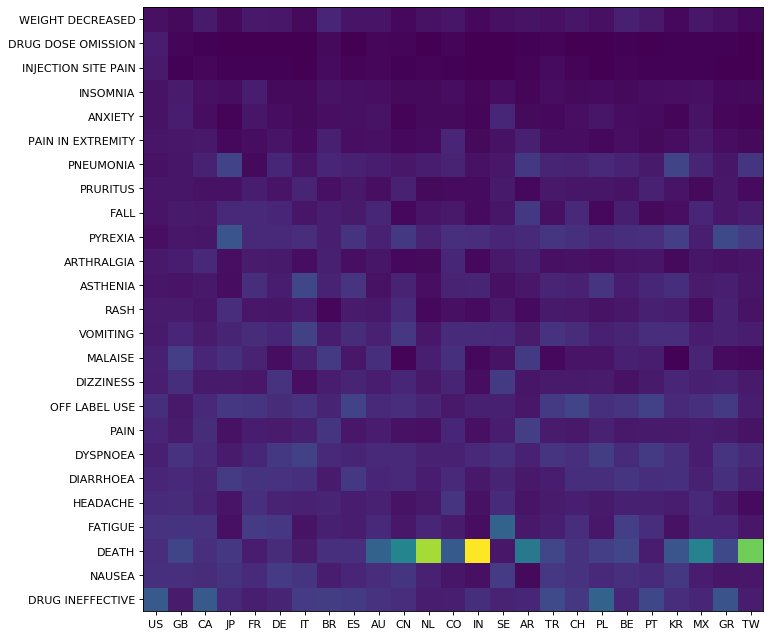

In [628]:
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()

In [406]:
df  = top25_c_by_r

In [685]:
#normalizing like this does not make much sense: 
# normalized_df=(df-df.mean())/df.std()
df=(df-df.min())/(df.max()-df.min())

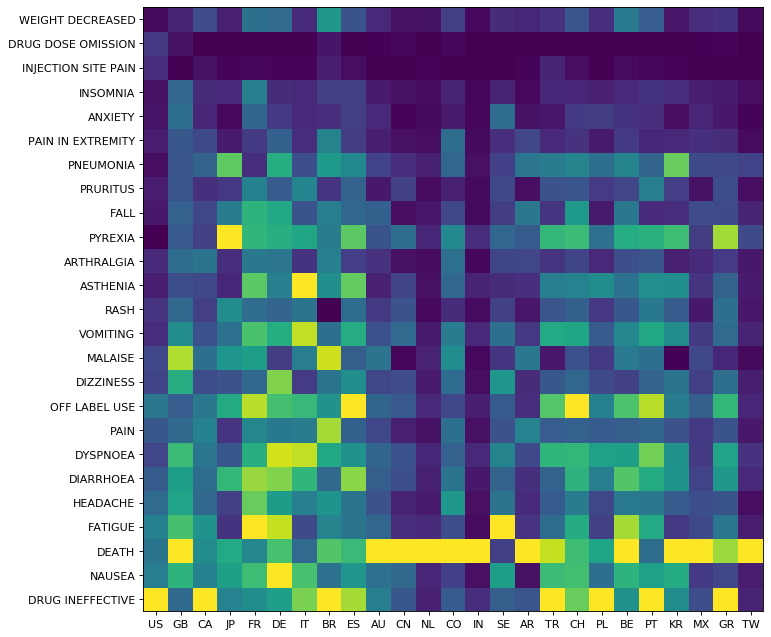

In [408]:
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()

In [400]:
df  = top25_c_by_r

In [309]:
#normalizing like this does not make much sense: 
# normalized_df=(df-df.mean())/df.std()
df=(df-df.mean())/df.std()

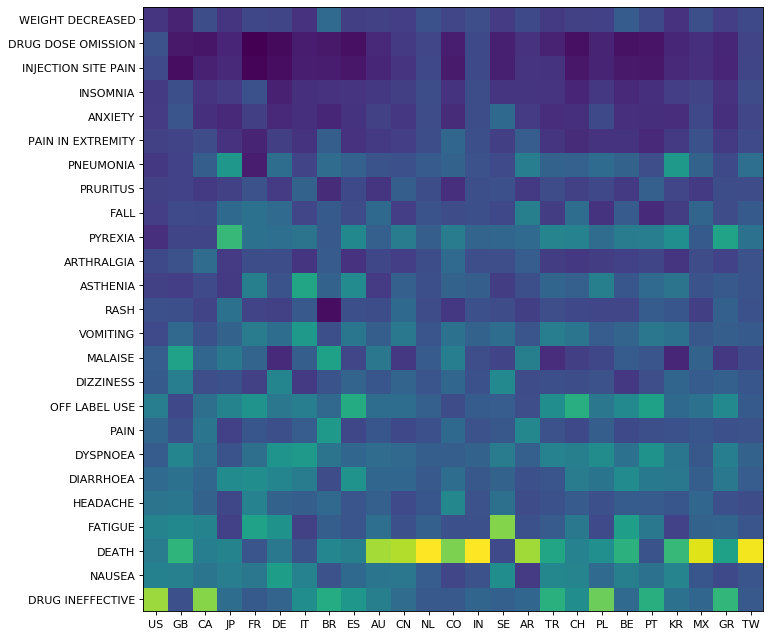

In [310]:
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()

Which countries are similar? Maybe we can reduce the dimensions, and visulize (+calculate) clusters.

In [560]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df.T)
print(pca.components_)
print(pca.explained_variance_ratio_)

[[-0.10215425 -0.09238534  0.96899413 -0.09712213 -0.06452134 -0.06706649
  -0.04315574 -0.04169232 -0.07141346 -0.03756094 -0.0429443  -0.03052678
  -0.04216161 -0.04593108 -0.0338223   0.01375022 -0.0146195  -0.04778621
   0.0149903  -0.01276825 -0.03749151 -0.02046886 -0.01151754 -0.0100401
  -0.03058459]
 [-0.36364091 -0.09261864 -0.01063562  0.34257905  0.17981252 -0.1371389
  -0.15270643  0.18003245 -0.27499993  0.09503518  0.38532608 -0.1747326
  -0.15512013 -0.26205586  0.19477208 -0.33995008  0.20874198 -0.10946119
  -0.0542756   0.17974887  0.13681956  0.05965107  0.02695184  0.04044729
   0.09741792]]
[0.70707556 0.08735523]


In [610]:
top_reactions.iloc[[0, 3, 8, 10, 13, 15]]

,term,count
0,DRUG INEFFECTIVE,733191
3,FATIGUE,439328
8,OFF LABEL USE,324957
10,MALAISE,292069
13,ASTHENIA,231802
15,PYREXIA,212052


In [562]:
df.shape

(25, 25)

In [563]:
df_pca.shape

(25, 2)

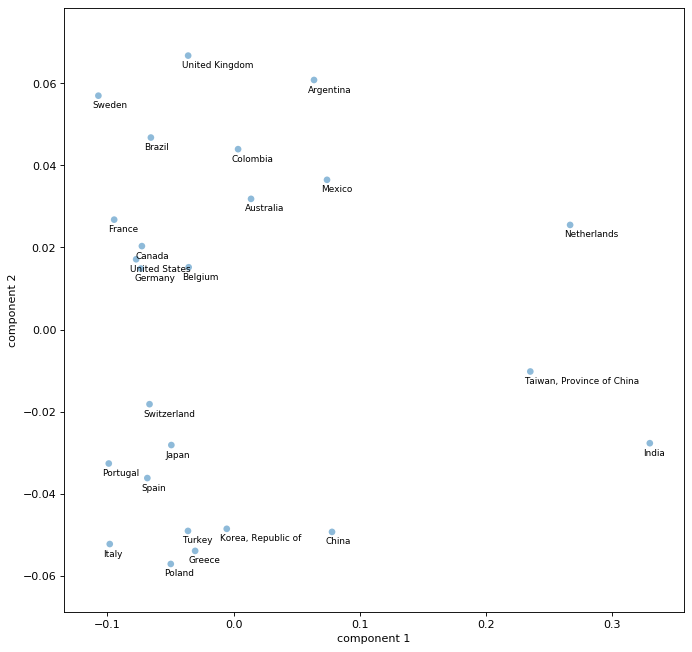

In [593]:
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(df_pca[:, 0], df_pca[:, 1], edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
v_c = 0.003
h_c = 0.005
for i, col in enumerate(df.columns):
    plt.annotate(country_name[col], (df_pca[i, 0]-h_c, df_pca[i, 1]-v_c),size=8)

In [624]:
country_cluster_1 = ['SE','GB','AR','BR','CO','AU','MX', 'FR','CA','US','DE','BE']
country_cluster_2 = ['CH','JP','PT','ES','IT','TR','GR','KR','PL','CN']
country_cluster_3 = ['IN','TW','NL']

In [623]:
for country_code in country_cluster_1:
    print(country_name[country_code], end = ', ')

Sweden, United Kingdom, Argentina, Brazil, Colombia, Australia, Mexico, France, Canada, United States, Germany, Belgium, 

In [622]:
for country_code in country_cluster_2:
    print(country_name[country_code], end=', ')

Switzerland, Japan, Portugal, Spain, Italy, Turkey, Greece, Korea, Republic of, Poland, China, 

In [642]:
df  = top25_c_by_r

In [643]:
df=(df/df.sum())

In [637]:
# df =  df.drop(['US','GB','CA'], axis=1)

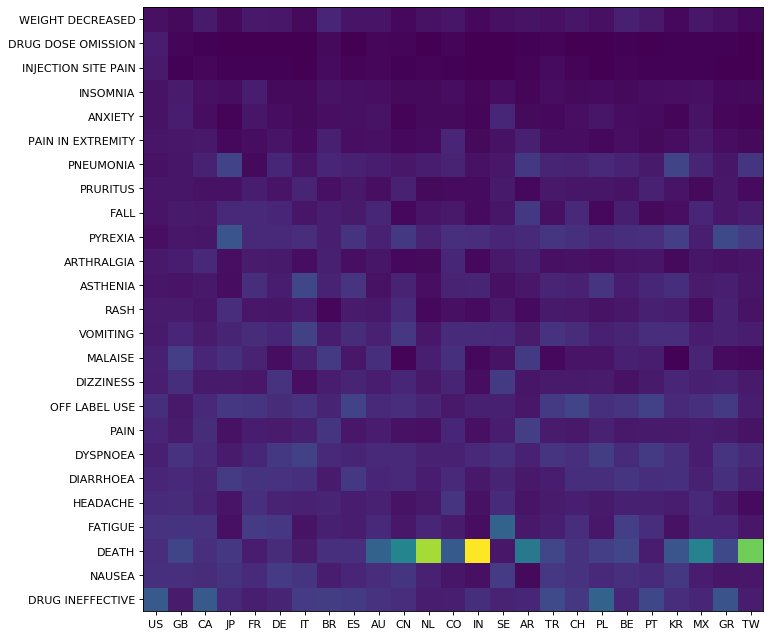

In [638]:
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()

Rearranging columns of the dataframe based on clusters

In [686]:
df = df[country_cluster_1+country_cluster_2+country_cluster_3]

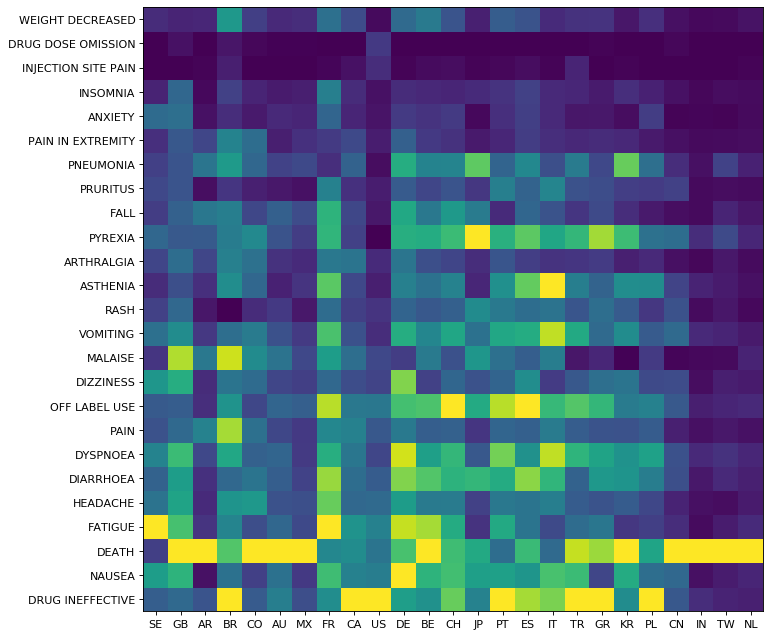

In [891]:
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()

In [892]:
df  = top25_c_by_100_r

In [893]:
df=(df/df.sum())

In [894]:
# df =  df.drop(['US','GB','CA'], axis=1)

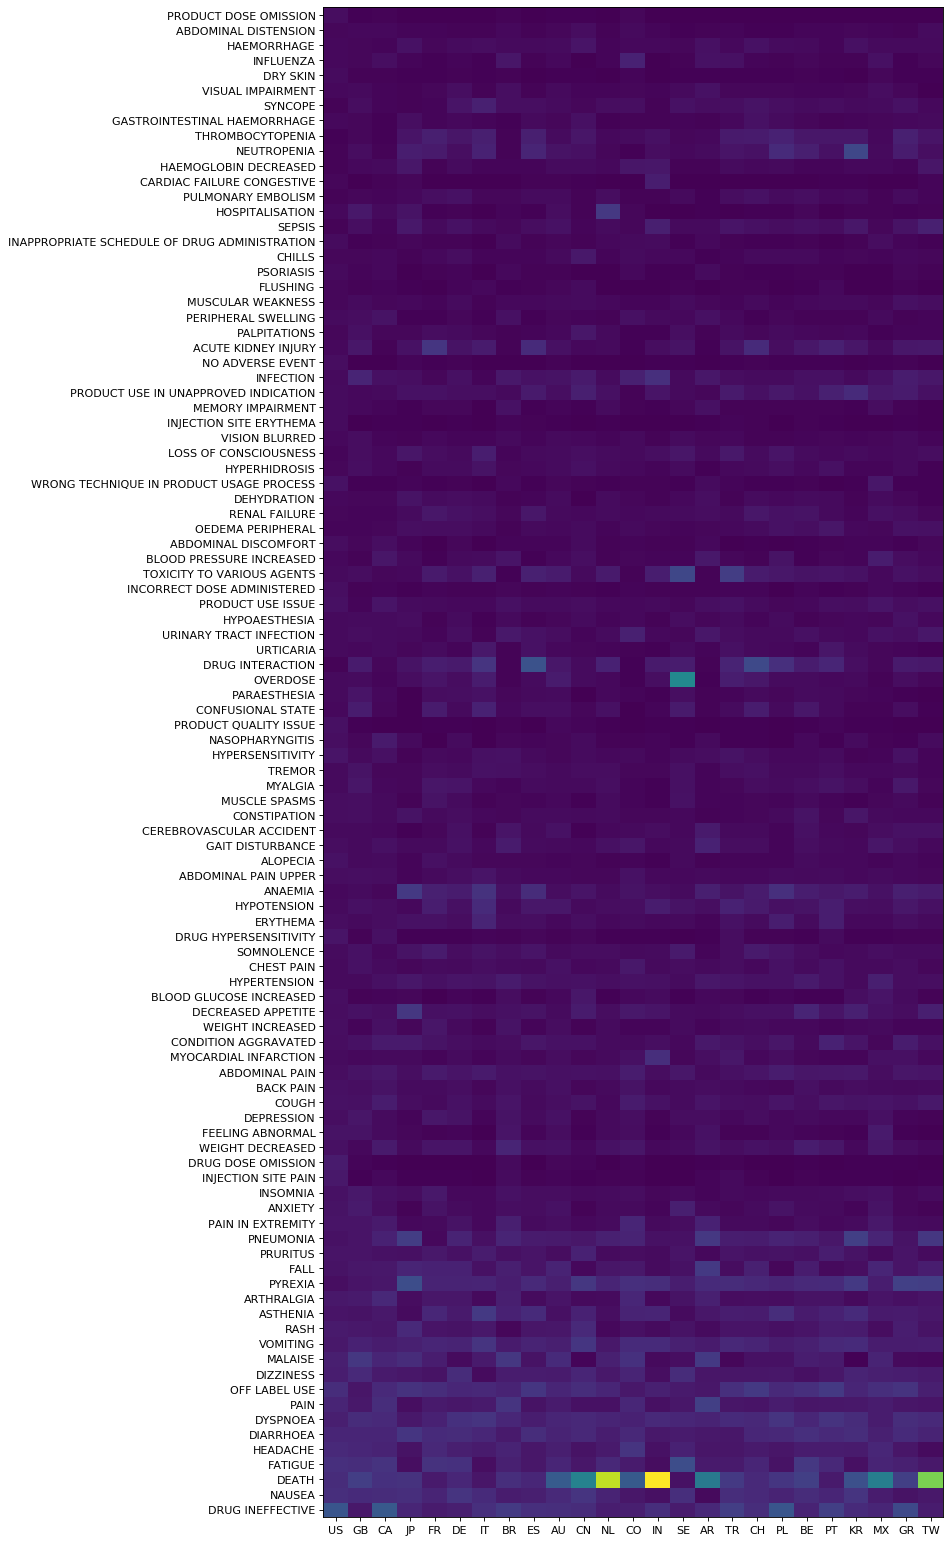

In [898]:
figure(num=None, figsize=(10, 25), dpi=80, facecolor='w', edgecolor='k')
plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()

In [899]:
country_name['SE']

'Sweden'

In [903]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df.T)
print(pca.components_)
print(pca.explained_variance_ratio_)

[[-6.23942867e-02 -5.97200114e-02  9.68592427e-01 -6.14371334e-02
  -3.88098707e-02 -3.65235202e-02 -1.17061050e-02 -1.90861088e-02
  -3.84041755e-02 -1.60382268e-02 -1.90878833e-02 -4.68200141e-03
  -2.62448243e-02 -2.26595353e-02 -1.70828791e-02  3.92102877e-02
   2.95700723e-03 -3.16350684e-02  3.38312895e-02 -8.60428620e-04
  -2.58376868e-02 -1.06201595e-02 -7.65740312e-03 -6.90971959e-03
  -1.64224620e-02 -1.71127820e-03 -1.96965761e-02  6.41043176e-03
  -5.07148500e-03 -2.22535218e-02  4.75787744e-02 -1.42805937e-02
  -1.12148653e-02  9.32100799e-03  1.29287596e-02 -1.44619028e-03
  -9.50597829e-03 -2.38340302e-02 -1.12463230e-02 -3.36251541e-02
  -1.61863866e-02 -4.05658021e-02 -1.13139473e-02 -1.82847028e-02
   3.41397004e-03  1.07289433e-02 -5.52143565e-03 -1.51189721e-02
  -2.21326242e-02 -1.53587245e-02 -1.85745377e-02  3.79774066e-03
  -2.77091316e-03 -3.92864574e-02 -2.48579263e-02 -8.62449692e-02
  -5.14830052e-02 -3.10880984e-02  1.15805256e-02 -8.21023073e-03
   4.03345

In [904]:
df.shape

(100, 25)

In [905]:
df_pca.shape

(25, 2)

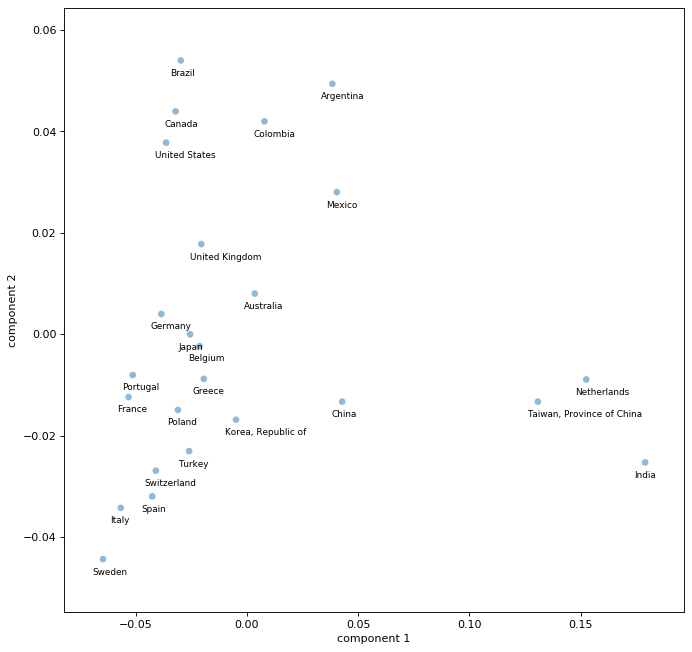

In [910]:
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(df_pca[:, 0], df_pca[:, 1], edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
v_c = 0.003
h_c = 0.005
for i, col in enumerate(df.columns):
    plt.annotate(country_name[col], (df_pca[i, 0]-h_c, df_pca[i, 1]-v_c),size=8)

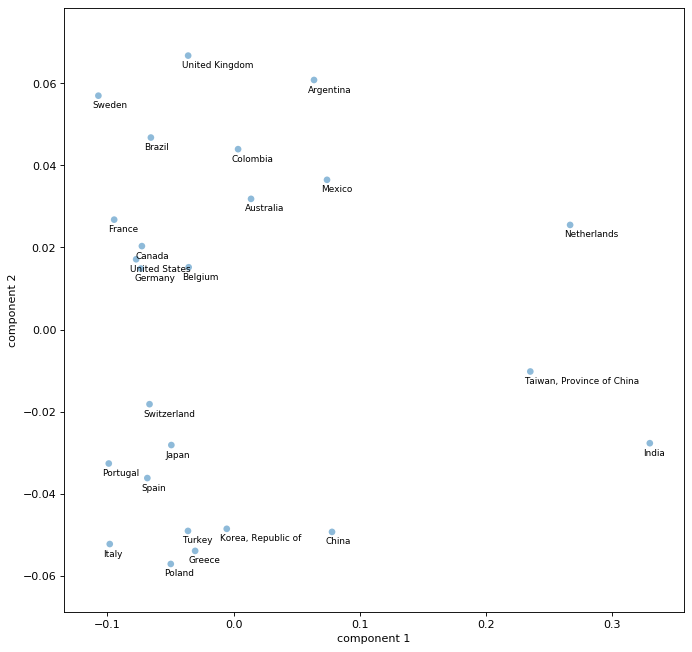

In [593]:
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(df_pca[:, 0], df_pca[:, 1], edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
v_c = 0.003
h_c = 0.005
for i, col in enumerate(df.columns):
    plt.annotate(country_name[col], (df_pca[i, 0]-h_c, df_pca[i, 1]-v_c),size=8)

###### ANSWER:

Looks like YES, **different adverse events** are reported in **different countries**.

Furthermore:
- We see that certain countries have similar patterns in terms of drug reactions reported:
    - **Netherlands, Taiwan and India** cluster together because reports of Death seem to be very high from these countries.
    - The rest of the crowd is split into 2 clusters:
        - Cluster 1: Sweden, United Kingdom, Argentina, Brazil, Colombia, Australia, Mexico, France, Canada, United States, Germany, Belgium
        - Cluster 2: Switzerland, Japan, Portugal, Spain, Italy, Turkey, Greece, Korea, Republic of, Poland, China
        - These 2 clusters differ by mostly the second PC
- When we do the PCA analysis, we see that the top 2 principal components that explain 79% (~71+~8%) of the variance and correspond mainly to the following drug reactions:
    - Death
    - Combination of DRUG INEFFECTIVE, FATIGUE, OFF LABEL USE, MALAISE, ASTHENIA, PYREXIA,

###### 2. What are the different adverse events associated with different disease areas?

Relevant fields:
- `patient.reaction.reactionmeddrapt` : **Patient reaction, as a MedDRA term. Note that these terms are encoded in British English. For instance, diarrhea is spelled diarrohea. MedDRA is a standardized medical terminology. DRUG REACTION / ADVERSE EVENT TYPE**          
- `patient.drug.drugindication` :  **Indication for the drug’s use. DRUG INDICATION / DISEASE AREA**

In [761]:
top_dis_areas = query("&count=patient.drug.drugindication.exact")
top_dis_areas.head(10)

,term,count
0,PRODUCT USED FOR UNKNOWN INDICATION,2694281
1,RHEUMATOID ARTHRITIS,612292
2,MULTIPLE SCLEROSIS,497499
3,HYPERTENSION,375888
4,PAIN,261658
5,PSORIASIS,259440
6,DIABETES MELLITUS,242301
7,DEPRESSION,224270
8,PLASMA CELL MYELOMA,217973
9,TYPE 2 DIABETES MELLITUS,205001


In [762]:
top_reactions = query("&count=patient.reaction.reactionmeddrapt.exact")
top_reactions.head(10)

,term,count
0,DRUG INEFFECTIVE,733191
1,NAUSEA,485098
2,DEATH,474541
3,FATIGUE,439328
4,HEADACHE,388310
5,DIARRHOEA,359872
6,DYSPNOEA,344540
7,PAIN,326354
8,OFF LABEL USE,324957
9,DIZZINESS,313617


In [765]:
results = query("&search=patient.drug.drugindication.exact:\"RHEUMATOID ARTHRITIS\"&count=patient.reaction.reactionmeddrapt.exact")
results.head(10)

,term,count
0,DRUG INEFFECTIVE,66174
1,RHEUMATOID ARTHRITIS,46076
2,INJECTION SITE PAIN,44805
3,ARTHRALGIA,42584
4,PAIN,36150
5,INJECTION SITE ERYTHEMA,28149
6,PAIN IN EXTREMITY,26158
7,FATIGUE,25487
8,HEADACHE,23981
9,NAUSEA,20821


In [771]:
results = query("&search=patient.drug.drugindication.exact:\"MULTIPLE SCLEROSIS\"&count=patient.reaction.reactionmeddrapt.exact")
results.head(10)

,term,count
0,FATIGUE,42655
1,MULTIPLE SCLEROSIS RELAPSE,40050
2,HEADACHE,26594
3,FALL,26252
4,GAIT DISTURBANCE,24487
5,MULTIPLE SCLEROSIS,21455
6,MEMORY IMPAIRMENT,20811
7,NAUSEA,19063
8,ASTHENIA,18711
9,PAIN,18430


In [779]:
print(results.head())

                      term  count
0  BLOOD GLUCOSE INCREASED  31242
1                   NAUSEA  15657
2         WEIGHT DECREASED  10524
3  BLOOD GLUCOSE DECREASED   8500
4                DIARRHOEA   8319


In [784]:
for i, d_a in enumerate(list(top_dis_areas.term)):
    results = query("&search=patient.drug.drugindication.exact:\""+d_a+"\"&count=patient.reaction.reactionmeddrapt.exact")
    print(d_a)
    print(results.head(10))
    if i > 10: break

PRODUCT USED FOR UNKNOWN INDICATION
               term   count
0  DRUG INEFFECTIVE  172379
1             DEATH  125463
2           FATIGUE  102186
3            NAUSEA  101916
4         DIARRHOEA   87574
5          HEADACHE   84506
6          DYSPNOEA   78800
7           MALAISE   73939
8         DIZZINESS   70708
9              PAIN   67077
RHEUMATOID ARTHRITIS
                      term  count
0         DRUG INEFFECTIVE  66174
1     RHEUMATOID ARTHRITIS  46076
2      INJECTION SITE PAIN  44805
3               ARTHRALGIA  42584
4                     PAIN  36150
5  INJECTION SITE ERYTHEMA  28149
6        PAIN IN EXTREMITY  26158
7                  FATIGUE  25487
8                 HEADACHE  23981
9                   NAUSEA  20821
MULTIPLE SCLEROSIS
                         term  count
0                     FATIGUE  42655
1  MULTIPLE SCLEROSIS RELAPSE  40050
2                    HEADACHE  26594
3                        FALL  26252
4            GAIT DISTURBANCE  24487
5          MULTIPLE 

In [918]:
for i, d_a in enumerate(list(top_dis_areas.term)[:10]):
    results = query("&search=patient.drug.drugindication.exact:\""+d_a+"\"&count=patient.reaction.reactionmeddrapt.exact")
    print('new disease area: ',d_a)
    for reaction in list(results.term)[:10]:
        if reaction not in list(top_reactions.term)[:25]:
            print(reaction)
    print()

new disease area:  PRODUCT USED FOR UNKNOWN INDICATION

new disease area:  RHEUMATOID ARTHRITIS
RHEUMATOID ARTHRITIS
INJECTION SITE ERYTHEMA

new disease area:  MULTIPLE SCLEROSIS
MULTIPLE SCLEROSIS RELAPSE
GAIT DISTURBANCE
MULTIPLE SCLEROSIS
MEMORY IMPAIRMENT

new disease area:  HYPERTENSION
HYPERTENSION
BLOOD PRESSURE INCREASED

new disease area:  PAIN
TOXICITY TO VARIOUS AGENTS
OVERDOSE

new disease area:  PSORIASIS
PSORIASIS
INJECTION SITE ERYTHEMA

new disease area:  DIABETES MELLITUS
MYOCARDIAL INFARCTION
CARDIAC FAILURE CONGESTIVE
BLOOD GLUCOSE INCREASED
CEREBROVASCULAR ACCIDENT
CORONARY ARTERY DISEASE
CARDIAC DISORDER

new disease area:  DEPRESSION
DEPRESSION
SUICIDAL IDEATION
FEELING ABNORMAL

new disease area:  PLASMA CELL MYELOMA
PLASMA CELL MYELOMA
NEUROPATHY PERIPHERAL
WHITE BLOOD CELL COUNT DECREASED

new disease area:  TYPE 2 DIABETES MELLITUS
BLOOD GLUCOSE INCREASED
BLOOD GLUCOSE DECREASED
BLADDER CANCER
DECREASED APPETITE



In [919]:
for i, d_a in enumerate(list(top_dis_areas.term)[:10]):
    results = query("&search=patient.drug.drugindication.exact:\""+d_a+"\"&count=patient.reaction.reactionmeddrapt.exact")
    print('new disease area: ',d_a)
    for reaction in list(results.term)[:10]:
        if reaction in list(top_reactions.term)[:25]:
            print(reaction)
    print()

new disease area:  PRODUCT USED FOR UNKNOWN INDICATION
DRUG INEFFECTIVE
DEATH
FATIGUE
NAUSEA
DIARRHOEA
HEADACHE
DYSPNOEA
MALAISE
DIZZINESS
PAIN

new disease area:  RHEUMATOID ARTHRITIS
DRUG INEFFECTIVE
INJECTION SITE PAIN
ARTHRALGIA
PAIN
PAIN IN EXTREMITY
FATIGUE
HEADACHE
NAUSEA

new disease area:  MULTIPLE SCLEROSIS
FATIGUE
HEADACHE
FALL
NAUSEA
ASTHENIA
PAIN

new disease area:  HYPERTENSION
DRUG INEFFECTIVE
DIZZINESS
DYSPNOEA
NAUSEA
DIARRHOEA
FATIGUE
HEADACHE
FALL

new disease area:  PAIN
DRUG INEFFECTIVE
PAIN
NAUSEA
DEATH
FATIGUE
HEADACHE
VOMITING
DIZZINESS

new disease area:  PSORIASIS
DRUG INEFFECTIVE
INJECTION SITE PAIN
DIARRHOEA
HEADACHE
NAUSEA
ARTHRALGIA
FATIGUE
PRURITUS

new disease area:  DIABETES MELLITUS
DRUG INEFFECTIVE
NAUSEA
DIARRHOEA
DYSPNOEA

new disease area:  DEPRESSION
DRUG INEFFECTIVE
NAUSEA
ANXIETY
DIZZINESS
HEADACHE
FATIGUE
INSOMNIA

new disease area:  PLASMA CELL MYELOMA
PNEUMONIA
DEATH
FATIGUE
DIARRHOEA
RASH
ASTHENIA
NAUSEA

new disease area:  TYPE 2 DIABETES ME

###### ANSWER:

###### 3. What drugs tend to be taken together?  

Relevant fields:
- `patient.drug.openfda.brand_name` : **Brand or trade name of the drug product. DRUG NAME**
- `patient.drug.openfda.generic_name` : Generic name(s) of the drug product.

In [991]:
top_drugs = query("&count=patient.drug.openfda.brand_name.exact&limit=1000")
top_drugs.head(25)

,term,count
0,ENBREL,505631
1,HUMIRA,459208
2,ECOTRIN,331225
3,ASPIRIN 325,330143
4,BAYER LOW DOSE,328604
5,BUFFERIN,326761
6,LOW DOSE ASPIRIN,326321
7,LOW DOSE ASPIRIN ENTERIC SAFETY COATED,326321
8,LOW DOSE ASPIRIN LOW DOSE,326321
9,ASPIRIN LOW DOSE,326235


In [985]:
top_drugs[top_drugs.term.str.contains('ASPIRIN')]

,term,count
3,ASPIRIN 325,330143
6,LOW DOSE ASPIRIN,326321
7,LOW DOSE ASPIRIN ENTERIC SAFETY COATED,326321
8,LOW DOSE ASPIRIN LOW DOSE,326321
9,ASPIRIN LOW DOSE,326235
...,...,...
632,MOORE MEDICAL EXTRA STRENGTH NON ASPIRIN,90680
633,MOORE MEDICAL NON ASPIRIN,90680
649,PHYSICIANSCARE NON ASPIRIN EXTRA STRENGTH,90680
661,SHOPRITE NON-ASPIRIN,90680


In [1025]:
top_drugs = query("&count=patient.drug.openfda.generic_name.exact&limit=1000")
top_drugs.head(10)

,term,count
0,ETANERCEPT,505631
1,ADALIMUMAB,459208
2,ASPIRIN,346100
3,ASPIRIN 81 MG,325826
4,ASPIRIN 325 MG,325744
5,ASPIRIN 81MG,319627
6,METHOTREXATE SODIUM,290720
7,FUROSEMIDE,260480
8,METHOTREXATE,249580
9,PREDNISONE,244889


In [987]:
top_drugs[top_drugs.term.str.contains('ASPIRIN')]

,term,count
2,ASPIRIN,346100
3,ASPIRIN 81 MG,325826
4,ASPIRIN 325 MG,325744
5,ASPIRIN 81MG,319627
490,"ACETAMINOPHEN, ASPIRIN (NSAID) AND CAFFEINE",11674
668,"ACETAMINOPHEN, ASPIRIN, AND CAFFEINE",6390
725,"ACETAMINOPHEN, ASPIRIN (NSAID), AND CAFFEINE",5519
771,ASPIRIN AND DIPYRIDAMOLE,4924
911,BAYER ASPIRIN EXTRA STRENGTH,3329


**Argument for using the generic name instead of brand name of a drug!**

In [1003]:
HUMIRA = query("&search=patient.drug.openfda.brand_name.exact:\"HUMIRA\"&count=patient.drug.openfda.brand_name.exact&limit=1000")
HUMIRA.head(25)

,term,count
0,HUMIRA,459208
1,METHOTREXATE,75898
2,TREXALL,69092
3,XATMEP,69039
4,PREDNISONE,35482
5,ENBREL,34246
6,FOLIC ACID,33914
7,VITAMIN D,17236
8,ACID REDUCER,15626
9,ORENCIA,13826


In [1010]:
ADALIMUMAB = query("&search=patient.drug.openfda.generic_name.exact:\"ADALIMUMAB\"&count=patient.drug.openfda.generic_name.exact&limit=10")
ADALIMUMAB.head(25)

,term,count
0,ADALIMUMAB,459208
1,METHOTREXATE SODIUM,75898
2,METHOTREXATE,69092
3,PREDNISONE,35482
4,ETANERCEPT,34246
5,FOLIC ACID,33914
6,ERGOCALCIFEROL,17252
7,SULFASALAZINE,13859
8,ABATACEPT,13826
9,OMEPRAZOLE,12775


In [1012]:
ADALIMUMAB.tail()

,term,count
5,FOLIC ACID,33914
6,ERGOCALCIFEROL,17252
7,SULFASALAZINE,13859
8,ABATACEPT,13826
9,OMEPRAZOLE,12775


In [1014]:
for co_drug in list(ADALIMUMAB.term):
    print(list(top_drugs.term)[:100].index(co_drug))

3
1
2
4
0
5
14
7
6
16


In [1026]:
list(top_drugs.term).index('CYCLOPHOSPHAMIDE')

86

In [ ]:
m,n = 100,100
temp = np.zeros((m,n), dtype=np.int)

In [1035]:
co_drugs.head()

,term,count
0,INTERFERON BETA-1A,173024
1,NATALIZUMAB,22816
2,DALFAMPRIDINE,5413
3,BACLOFEN,4936
4,GABAPENTIN,4603


In [1038]:
co_drugs.loc[3]['count']

4936

In [1029]:
#for the top 100 drugs
for i, drug in enumerate(list(top_drugs.term)[:25]):
    co_drugs = query("&search=patient.drug.openfda.generic_name.exact:\""+drug+"\"&count=patient.drug.openfda.generic_name.exact&limit=25")
    for j, co_drug in enumerate(list(co_drugs.term)):
        co_drug_rank = j
        overall_drug_rank = list(top_drugs.term).index(co_drug)
        if((overall_drug_rank+1)/(co_drug_rank+1)>25):
            print(i,drug, co_drug_rank, co_drug, overall_drug_rank)
        if overall_drug_rank<100:
            temp[i,overall_drug_rank] = co_drugs.loc[j]['count'] 
    #if i>1: break

0 ETANERCEPT 7 SULFASALAZINE 209
0 ETANERCEPT 9 LEFLUNOMIDE 265
0 ETANERCEPT 13 HYDROXYCHLOROQUINE SULFATE 487
1 ADALIMUMAB 7 SULFASALAZINE 209
15 LEVOTHYROXINE SODIUM 1 LEVOTHYROXINE SODIUM ANHYDROUS 133
17 METFORMIN 10 METFORMIN HYDROCHLORIDE EXTENDED-RELEASE TABLETS 340
17 METFORMIN 11 METFORMIN HYDROCHLORIDE TABLET 337
17 METFORMIN 12 METFORMIN HYDROCHLORIDE TABLETS 341
18 ACETAMINOPHEN 1 ACETAMINOPHEN, DIPHENHYDRAMINE HCL 72
18 ACETAMINOPHEN 2 ACETAMINOPHEN 325MG 76
23 METOPROLOL TARTRATE 2 METOROPROLOL TARTRATE 171
24 INTERFERON BETA-1A 2 DALFAMPRIDINE 122
24 INTERFERON BETA-1A 3 BACLOFEN 138


In [1005]:
for i, reaction in enumerate(list(top_reactions.term)[:m]):
    #create drug reaction row
    for j, country in enumerate(list(top_countries.term)[:n]):
        #add country to the reaction row
        results = query("&search=occurcountry:\""+country+"\"+AND+patient.reaction.reactionmeddrapt:\""+reaction+"\"&count=patient.reaction.reactionmeddrapt.exact")
        count = int(results.head(1)["count"])
        #print(country,reaction,count)
        temp[i,j] = count

,term,count
0,ADALIMUMAB,459208
1,METHOTREXATE SODIUM,75898
2,METHOTREXATE,69092
3,PREDNISONE,35482
4,ETANERCEPT,34246


###### ANSWER:

## Discussion & Future Directions

###### Limitations of the Data

* +limitation of the interface: ~250 calls / minute with an API key